In [21]:
# ! export OPENBLAS_NUM_THREADS=1

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

from mcmcmd.samplers import *
from mcmcmd.tests import *

# Helper functions

In [2]:

'''
Generate PP plots for beta
'''
def pp_plots_beta(marginal_samples_beta, successive_samples_beta):
    assert marginal_samples_beta.shape[1] == successive_samples_beta.shape[1]
    pp_step_size = 0.01 # plot every percentile
    p = marginal_samples_beta.shape[1]
    labels = [rf'$\beta_{i}$' for i in range(1,p+1)]

    x_pp = geweke_functions(marginal_samples_beta)
    y_pp = geweke_functions(successive_samples_beta)
    dim_grid = p

    # Check distributions of samples
    x_pp_1 = x_pp[:, :p]
    y_pp_1 = y_pp[:, :p]

    for j in range(dim_grid):
        plt.subplot(dim_grid, dim_grid, j+1)
        plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
        prob_plot(x_pp_1[:, j], y_pp_1[:, j], step=pp_step_size)
        plt.title(labels[j])
        if j==0:
            plt.tick_params(left=True, labelleft=True)
    plt.show()

    # Check distributions of sample cross-products
    x_pp_2 = x_pp[:, p:]
    y_pp_2 = y_pp[:, p:]
    theta2_count = int(p*(p+1)/2)

    ind_plot = 0
    ind_xlabel = 0
    ind_ylabel = 0
    for j in range(dim_grid**2):
        pos_hor = j % dim_grid + 1
        pos_vert = j // dim_grid + 1
        if pos_hor <= pos_vert:
            plt.subplot(dim_grid, dim_grid, j+1)
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            prob_plot(x_pp_2[:, ind_plot], y_pp_2[:, ind_plot], step=pp_step_size)
            ind_plot += 1
        if pos_hor == 1:
            plt.ylabel(labels[ind_ylabel])
            ind_ylabel += 1
            plt.tick_params(left=True, labelleft=True)
        if pos_vert == dim_grid:
            plt.xlabel(labels[ind_xlabel])
            ind_xlabel += 1
            plt.tick_params(bottom=True, labelbottom=True)
    plt.show()

'''
RJ Bayesian Lasso model based on (Chen, Wang, and McKeown 2011), with approximate sampling method from (Korattikara, Chen, and Welling 2014)
'''
class bayes_lasso_sampler(model_sampler):
    def __init__(self, **kwargs):
      self._mode = 'exact'
      super().__init__(**kwargs)

      # Check inputs
      for attr in ['_n', '_p', '_Lambda', '_tau', '_sigma', '_epsilon_update', '_epsilon_birth']:
          assert hasattr(self, attr)
      self._n = int(self._n)
      self._p = int(self._p)
      assert onp.all(onp.array([self._n, self._p, self._Lambda, self._tau,
                                self._sigma, self._epsilon_update, self._epsilon_birth]) > 0)
      assert self._mode in ('exact', 'approx')
      if self._mode == 'approx':
        assert hasattr(self, '_epsilon_approx')
        assert hasattr(self, '_batch_size')
        assert onp.all(onp.array([self._epsilon_approx, self._batch_size]) > 0)
      pass

    @property
    def sample_dim(self):
      # y + beta
      return self._n + self._p

    @property
    def theta_indices(self):
      return onp.arange(self._n, self._n + self._p)

    def log_prior(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
      return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k+1) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum()

    def log_likelihood(self, beta=None, subset=None, return_components=False):
      if beta is None:
        beta = self._beta
      if subset is None:
        subset = onp.arange(self._n)
      l = norm.logpdf(x=self._y[subset, :],
                      loc=self._X[subset, :]@beta, scale=self._sigma)
      if return_components == False:
        l = l.sum()
      return l

    def log_joint(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
      l_prior = self.log_prior(beta=beta, gamma=gamma, k=k)
      l_likelihood = self.log_likelihood(beta=beta)
      return l_prior + l_likelihood

    def drawData(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._X = rng.normal(size=[self._n, self._p])
      self._p_k = onp.exp(onp.arange(1, self._p+1) * onp.log(self._Lambda) -
                          self._Lambda - loggamma(1+onp.arange(1, self._p+1)))
      self._p_k = self._p_k/self._p_k.sum()
      pass

    def drawPrior(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._beta = onp.zeros(shape=[self._p, 1])
      self._k = rng.choice(a=onp.arange(1, self._p+1), p=self._p_k)

      self._gamma = rng.choice(self._p, size=self._k, replace=False)
      self._beta[self._gamma, :] = rng.laplace(
          scale=self._tau, size=[self._k, 1])
      return self._beta.flatten()

    def drawLikelihood(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._y = rng.normal(loc=self._X @ self._beta,
                           scale=self._sigma).reshape(self._n, 1)
      return self._y.flatten()

    def drawPosterior(self, rng=None):
      if rng is None:
          rng = self._rng_s

      j, k_proposal, gamma_proposal, beta_proposal = self.getProposal(rng)

      if self._mode == 'exact':
        self.updateMH(j, k_proposal, gamma_proposal, beta_proposal, rng)
      elif self._mode == 'approx':
        self.updateApproxMH(j, k_proposal, gamma_proposal, beta_proposal, rng)

      return self._beta.flatten()

    def getProposal(self, rng):
      beta_proposal = self._beta.copy()
      if self._p == 1:
        k_proposal = self._k
      elif self._k == 1:
        k_proposal = self._k + rng.choice([0, 1])
      elif self._k == self._p:
        k_proposal = self._k + rng.choice([-1, 0])
      else:
        k_proposal = self._k + rng.choice([-1, 0, 1])

      if k_proposal == self._k:  # update
        j = rng.choice(self._gamma)
        gamma_proposal = self._gamma
        beta_proposal[j, :] += rng.normal(scale=self._epsilon_update)
      elif k_proposal == self._k + 1:  # birth
        j = rng.choice(onp.setdiff1d(onp.arange(self._p), self._gamma))
        gamma_proposal = onp.hstack([self._gamma, j])
        beta_proposal[j, :] = rng.normal(scale=self._epsilon_birth)
      elif k_proposal == self._k - 1:  # death
        j = rng.choice(self._gamma)
        gamma_proposal = self._gamma[self._gamma != j]
        beta_proposal[j, :] = 0.
      return j, k_proposal, gamma_proposal, beta_proposal

    # Calculate p(gamma -> gamma_proposal)
    def gammaProposal_prob(self, gamma, gamma_proposal):
      k = gamma.shape[0]
      k_proposal = gamma_proposal.shape[0]
      prob = 0.
      if self._p == 1:
        return prob
      if k == 1 and onp.intersect1d(gamma, gamma_proposal).shape[0] == 1:
        if k_proposal == k+1:
          prob = 0.5 * 1./(self._p - k)
        elif k_proposal == k:
          prob = 0.5
      elif 1 < k and k < self._p and onp.abs(onp.intersect1d(gamma, gamma_proposal).shape[0] - k) <= 1:
        if k_proposal == k+1:
          prob = 1./3. * 1./(self._p - k)
        elif k_proposal == k:
          prob = 1./3.
        elif k_proposal == k-1:
          prob = 1./3. * 1./k
      elif k == self._p and onp.intersect1d(gamma, gamma_proposal).shape[0] == self._p-1:
        if k_proposal == k:
          prob = 0.5
        elif k_proposal == k-1:
          prob = 0.5 * 1./k
      return prob

    # Metropolis-Hastings update
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      if k_proposal == self._k:  # update
        MH_augment = 0.
      elif k_proposal == self._k + 1:  # birth
        MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) - float(norm.logpdf(beta_proposal[j, :], scale=self._epsilon_birth))
      elif k_proposal == self._k - 1:  # death
        MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) + float(norm.logpdf(self._beta[j, :], scale=self._epsilon_birth))

      diff_log_joint = self.log_joint(
          beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
      threshold = diff_log_joint + MH_augment

      log_u = onp.log(rng.uniform())
      if log_u <= threshold:
        self._k = k_proposal
        self._gamma = gamma_proposal
        self._beta = beta_proposal
      return log_u, threshold

    # Approximate Metropolis-Hastings update
    def updateApproxMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      # Calculate threshold
      u = rng.uniform()
      if k_proposal == self._k:  # update
        MH_augment = 0.
      elif k_proposal == self._k + 1:  # birth
        MH_augment = -onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) + onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) + float(norm.logpdf(beta_proposal[j, :], scale=self._epsilon_birth))
      elif k_proposal == self._k - 1:  # death
        MH_augment = -onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) + onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) - float(norm.logpdf(self._beta[j, :], scale=self._epsilon_birth))

      threshold = (onp.log(u) + self.log_prior() - self.log_prior(beta=beta_proposal,
                                                                  gamma=gamma_proposal, k=k_proposal) + MH_augment)/self._n

      l = 0
      l2 = 0
      sample = onp.array([])
      sample_size = 0
      permutation = rng.permutation(self._n)
      done = False

      while not done:
        batch_size = min(self._batch_size, self._n - sample_size)
        batch = permutation[sample_size:(sample_size+batch_size)]
        sample = onp.hstack([sample, batch])

        l_diff = self.log_likelihood(beta=beta_proposal, subset=batch, return_components=True) - \
            self.log_likelihood(subset=batch, return_components=True)
        l += l_diff.sum()
        l2 += (l_diff**2).sum()

        sample_size += batch_size

        l_sd = onp.sqrt((l2/sample_size - (l/sample_size)**2)
                        * sample_size/(sample_size-1))
        l_se = l_sd/onp.sqrt(sample_size) * onp.sqrt(1 -
                                                     (sample_size-1)/(self._n-1))

        if l_se > 0:
          test_stat = onp.abs(l-threshold)/l_se
          delta = 1 - t.cdf(test_stat, sample_size-1)
        else:
          delta = 0
        if delta <= self._epsilon_approx:
          if l >= threshold:
            self._k = k_proposal
            self._gamma = gamma_proposal
            self._beta = beta_proposal
          done = True
      pass

'''
Test a bayes_lasso_sampler
'''
def test(bayes_lasso, num_samples, print_results=True):
    marginal_samples = bayes_lasso.sample_mc(num_samples)

    marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
    marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
    marginal_samples_k = marginal_samples_gamma.sum(1)

    successive_samples = bayes_lasso.sample_sc(num_samples)
    successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
    successive_samples_gamma = (successive_samples_beta!=0).astype('int')
    successive_samples_k = successive_samples_gamma.sum(1)

    backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=50)
    backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
    backward_samples_gamma = (backward_samples_beta!=0).astype('int')
    backward_samples_k = backward_samples_gamma.sum(1)

    thinned_samples_geweke = onp.arange(0, num_samples, int(num_samples/1e5)).astype('int') # thinning for Geweke tests; will use 1e5 samples.
    time_start = perf_counter()
    res_geweke = geweke_test(geweke_functions(marginal_samples_beta[thinned_samples_geweke, :]), geweke_functions(successive_samples_beta[thinned_samples_geweke, :]), l=0.08, alpha=0.05)
    time_end = perf_counter()

    thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests
    time_start = perf_counter()
    f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
    res_wild = mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05)
    time_end = perf_counter()
    time_wild = onp.round(time_end - time_start, 3)
    

    time_start = perf_counter()
    res_backward = mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(10,1), alpha=0.05)
    time_end = perf_counter()
    time_backward = onp.round(time_end - time_start, 3)
    
    if print_results==True:
      print('Geweke test')
      print(res_geweke)
      print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

      print('Wild bootstrap MMD test')
      print(res_wild)
      print(f'Test time: {time_wild} seconds')

      print('Backward MMD test')
      print(res_backward)
      print(f'Test time: {time_backward} seconds')

      pp_plots_beta(marginal_samples_beta, successive_samples_beta)
      plt.show()
    
    return {'geweke':res_geweke, 'backward':res_backward, 'wild':res_wild}, {'mc': marginal_samples_beta, 'sc': successive_samples_beta, 'bc': backward_samples_beta}

'''
Test a bayes_lasso_sampler multiple times and save the results
'''
def run_experiment(bayes_lasso, experiment_name, num_trials=20):
    n=3; p=3
    Lambda=1; tau=1; sigma=1
    epsilon_update=2; epsilon_birth=epsilon_update
    num_samples = int(1e5)

    lst_results = []
    lst_samples = []
    for _ in range(num_trials):
        time_start = perf_counter()
        res, samples = test(bayes_lasso, num_samples=num_samples, print_results=False)

        lst_results.append(res)
        lst_samples.append(samples)

        time_end = perf_counter()
        print(f'Iteration time: {onp.round(time_end - time_start, 3)} seconds')

    with open('./results/bayes_lasso/experiment_' + experiment_name + '.pkl', 'wb') as f:
        pickle.dump(lst_results, f)
    with open('./samples/bayes_lasso/experiment_' + experiment_name + '.pkl', 'wb') as f:
        pickle.dump(lst_samples, f)

# Model

Given the multivariate linear regression model

\begin{equation}
  \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}

\begin{equation}
  \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^{2} \mathbf{I})
\end{equation}

In standard Lasso, we would introduce an L1 penalty to the objective function with a corresponding regularization parameter. Here, we instead promote sparsity by placing a (truncated) Poisson prior on the number $k$ of nonzero coefficients $\beta_{j}$ and drawing these coefficients from a Laplace distribution. Define the parameters $\mathbf{\Theta} = \{\lambda, \sigma, \tau, k, \mathbf{\gamma}, \mathbf{\beta}\}$ such that

\begin{equation}
  p(\mathbf{\Theta}) = p(k|\lambda) p(\mathbf{\gamma}|k) p(\beta_{j} | \tau, \gamma )
\end{equation}

\begin{equation}
  p(k|\lambda) = \frac{\exp{(-\lambda)} \lambda^{k}}{Ck!}, \quad k \in \{1,\ldots, p\}
\end{equation}
\begin{equation}
  p(\mathbf{\gamma}|k) = {p\choose k}^{-1}
\end{equation}

\begin{equation}
  p(\beta_{j} | \tau, \gamma ) = \begin{cases} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) & j \in \mathbf{\gamma} \\ \delta(\beta_{j}) & \text{otherwise} \end{cases}
\end{equation}

where $C$ is a normalization constant, $\delta$ is the Dirac delta function, and $\mathbf{\gamma}$ is a vector of the nonzero indices of $\mathbf{\beta}$.

The likelihood is given by

\begin{equation}
  p(\mathbf{y} | \sigma, \mathbf{\beta} ) = (2\pi)^{-\frac{n}{2}} \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})}
\end{equation}

Here, $\{\lambda, \sigma, \tau\}$ are fixed, but we could place priors on them, e.g., inverse-gamma (TODO?).

Then
\begin{equation}
 p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} ) \propto \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})} \frac{\exp{(-\lambda)} \lambda^{k}}{k!} {p\choose k}^{-1} \prod_{j\in \mathbf{\gamma}} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) \prod_{k \notin \mathbf{\gamma}} \delta(\beta_{k})
\end{equation}


The code for the `bayes_lasso_sampler` class is given in the Helper Functions section.

Now we will draw the marginal-conditional samples. The `sample_mc` function only returns $\{y_{i}, \mathbf{\beta}_{i}\}$, but it is easy to recover $\{k_{i}, \gamma_{i}\}$ if they are of interest.

In [3]:
n=3; p=3
Lambda=1; tau=1; sigma=1
epsilon_update=2; epsilon_birth=epsilon_update
num_samples = int(1e5)
nthreads = 5

In [4]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nthreads(nthreads)
bayes_lasso.drawData() # set X

In [5]:
marginal_samples = bayes_lasso.sample_mc(num_samples)
marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
# marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
# marginal_samples_k = marginal_samples_gamma.sum(1)

Each iteration of the reversible-jump MCMC posterior sampler proposes $k' \in \{k-1, k, k+1\}$ uniformly at random, disallowing $k<1$ and $k>p$. Thus, when $k \in \{1,p\}$, there are only two valid proposals, not three. Depending on the $k'$ chosen and the random walk step sizes $\epsilon_{\text{update}}, \epsilon_{\text{birth}}$, one of the following moves are made.

- Update: $k' = k$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma}, \beta'_{j} = \beta_{j} + \mathcal{N}(0, \epsilon_{\text{update}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )}, 1)}$

- Birth: $k' = k+1$
  - Choose $j \in \{k+1, \ldots, p\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \cup j$
  - Propose $\beta'_{j} = \mathcal{N}(0, \epsilon_{\text{birth}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{k'} & k'=p \\ \frac{1}{3} \frac{1}{k'} & 1<k<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & k=1 \\ \frac{1}{3} \frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & 1<k<p \end{cases} $

- Death: $k' = k-1$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \setminus j$ 
  - Propose $\beta'_{j} = 0, \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & k'=1 \\ \frac{1}{3} \frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & 1<k'<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{k} & k=p \\ \frac{1}{3} \frac{1}{k} & 1<k<p \end{cases} $

Now we draw the successive-conditional samples and burned-in backward samples

In [6]:
successive_samples = bayes_lasso.sample_sc(num_samples)
successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
# successive_samples_gamma = (successive_samples_beta!=0).astype('int')
# successive_samples_k = successive_samples_gamma.sum(1)

backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=100)
backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
# backward_samples_gamma = (backward_samples_beta!=0).astype('int')
# backward_samples_k = backward_samples_gamma.sum(1)

# Joint Distribution Tests

To check the posterior sampler, we first perform a Geweke test on the first and second empirical moments of the samples.

Notes on the code:
- `geweke_functions(S)` returns $[\mathbf{s}_{1}, \ldots, \mathbf{s}_{p}, \mathbf{s}_{1} \odot \mathbf{s}_{1}, \mathbf{s}_{1} \odot \mathbf{s}_{2}, \ldots, \mathbf{s}_{p} \odot \mathbf{s}_{p} ]$, where $\mathbf{s}_{j}$ is the $j^{\text{th}}$ column of $S$. The column means of the output are the first and second empirical moments of $\mathbf{S}$.
- The argument `l` to `geweke_test` controls the window size used to estimate the successive-conditional standard errors. Specifically, the window size is given by `l * num_samples`. 
- The argument `alpha` to `geweke_test` is the significance level of the tests.

In [7]:
thinned_samples_geweke = onp.arange(0, num_samples, int(num_samples/1e4)).astype('int') # thinning for Geweke tests; will use 1e5 samples.
time_start = perf_counter()
print(geweke_test(geweke_functions(marginal_samples_beta[thinned_samples_geweke, :]), geweke_functions(successive_samples_beta[thinned_samples_geweke, :]), l=0.15, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': array([ True, False, False, False, False, False, False, False, False]), 'p_value': array([0.0075424 , 0.09344335, 0.24935316, 0.51129217, 0.64914416,
       0.39059402, 0.42370412, 0.63235842, 0.43072321]), 'test_statistic': array([ 2.67189593, -1.67750717, -1.15192193, -0.65682699, -0.45495146,
        0.8585406 , -0.80001152,  0.47841   , -0.78795469]), 'critical_value': 1.959963984540054}
Test time: 0.395 seconds


Next, we perform two different MMD tests. First, the wild bootstrap version:

In [8]:
thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests; will use 1000 samples.
time_start = perf_counter()
f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
print(mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': False, 'p_value': 0.54, 'test_statistic': 1.3761928711167057, 'critical_value': 3.3548675036870708}
Test time: 1.175 seconds


Next, the backward version:

In [9]:
time_start = perf_counter()
print(mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(10,1), alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': False, 'p_value': 0.6, 'test_statistic': -0.12491142842918634, 'critical_value': 0.581342086661607, 'kernel_width': 1.0}
Test time: 8.133 seconds


All three tests fail to reject the null hypothesis that the distributions are the same. To confirm these results visually, we can examine the PP plots of the distributions of the (marginal-conditional and successive-conditional) samples and their cross-products. The closer the points are to the unit line, the better.

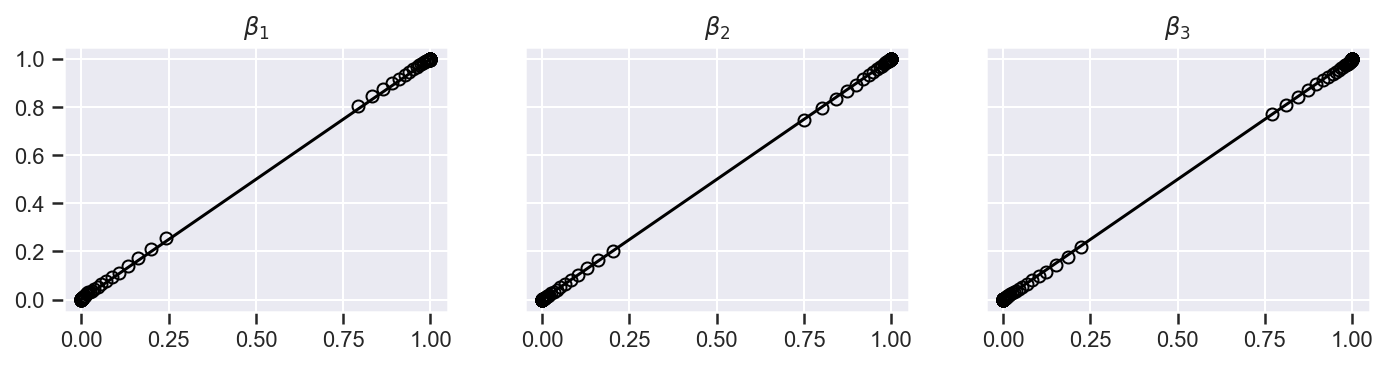

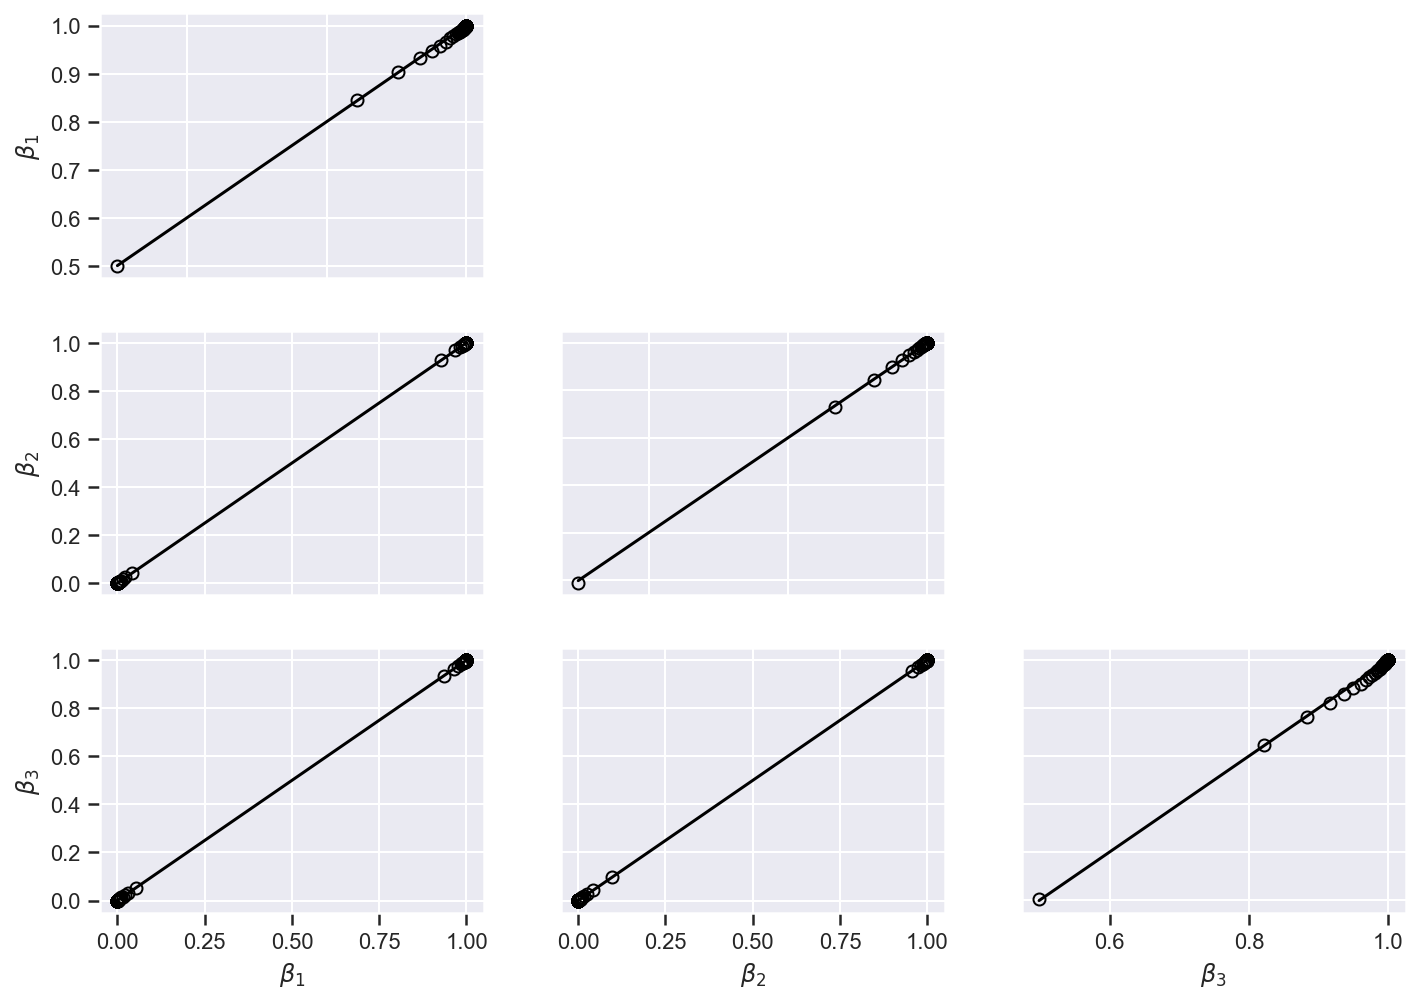

In [10]:
pp_plots_beta(marginal_samples_beta, successive_samples_beta)

Now, let's introduce intentional errors and see if the tests detect them.

Geweke test
{'result': array([False, False, False,  True, False,  True, False, False,  True]), 'p_value': array([3.15343198e-01, 1.79645216e-01, 4.82089836e-01, 9.32587341e-15,
       6.67346563e-01, 8.12003131e-09, 2.49728932e-01, 3.07546683e-01,
       1.79856130e-14]), 'test_statistic': array([-1.00407348, -1.34184821,  0.7029453 ,  7.74897861, -0.42979254,
        5.76594755,  1.15100803,  1.02038336,  7.66380687]), 'critical_value': 1.959963984540054}
Test time: 8.271 seconds
Wild bootstrap MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 16.094616471801285, 'critical_value': 2.552454303325842}
Test time: 1.07 seconds
Backward MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 3.8819971960037947, 'critical_value': 0.5781461950391531, 'kernel_width': 1.0}
Test time: 8.271 seconds


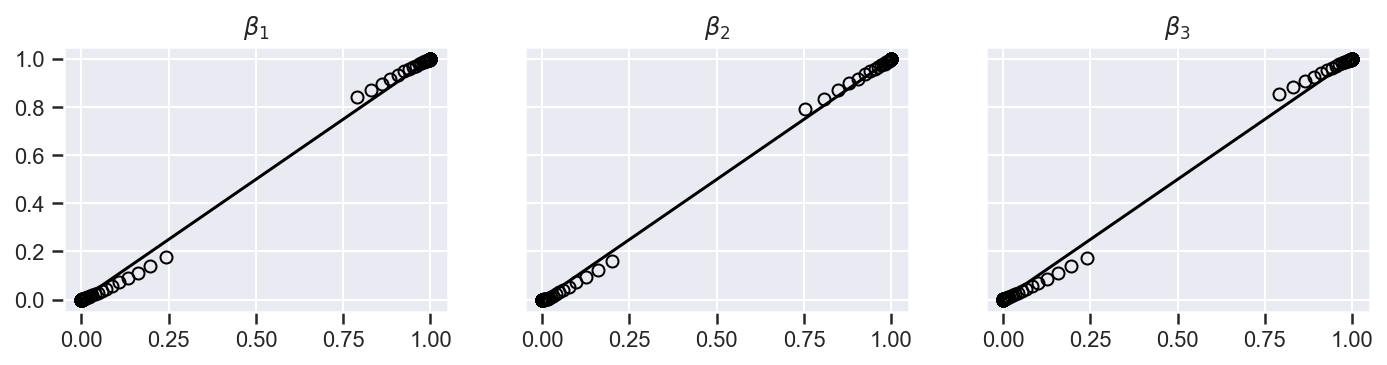

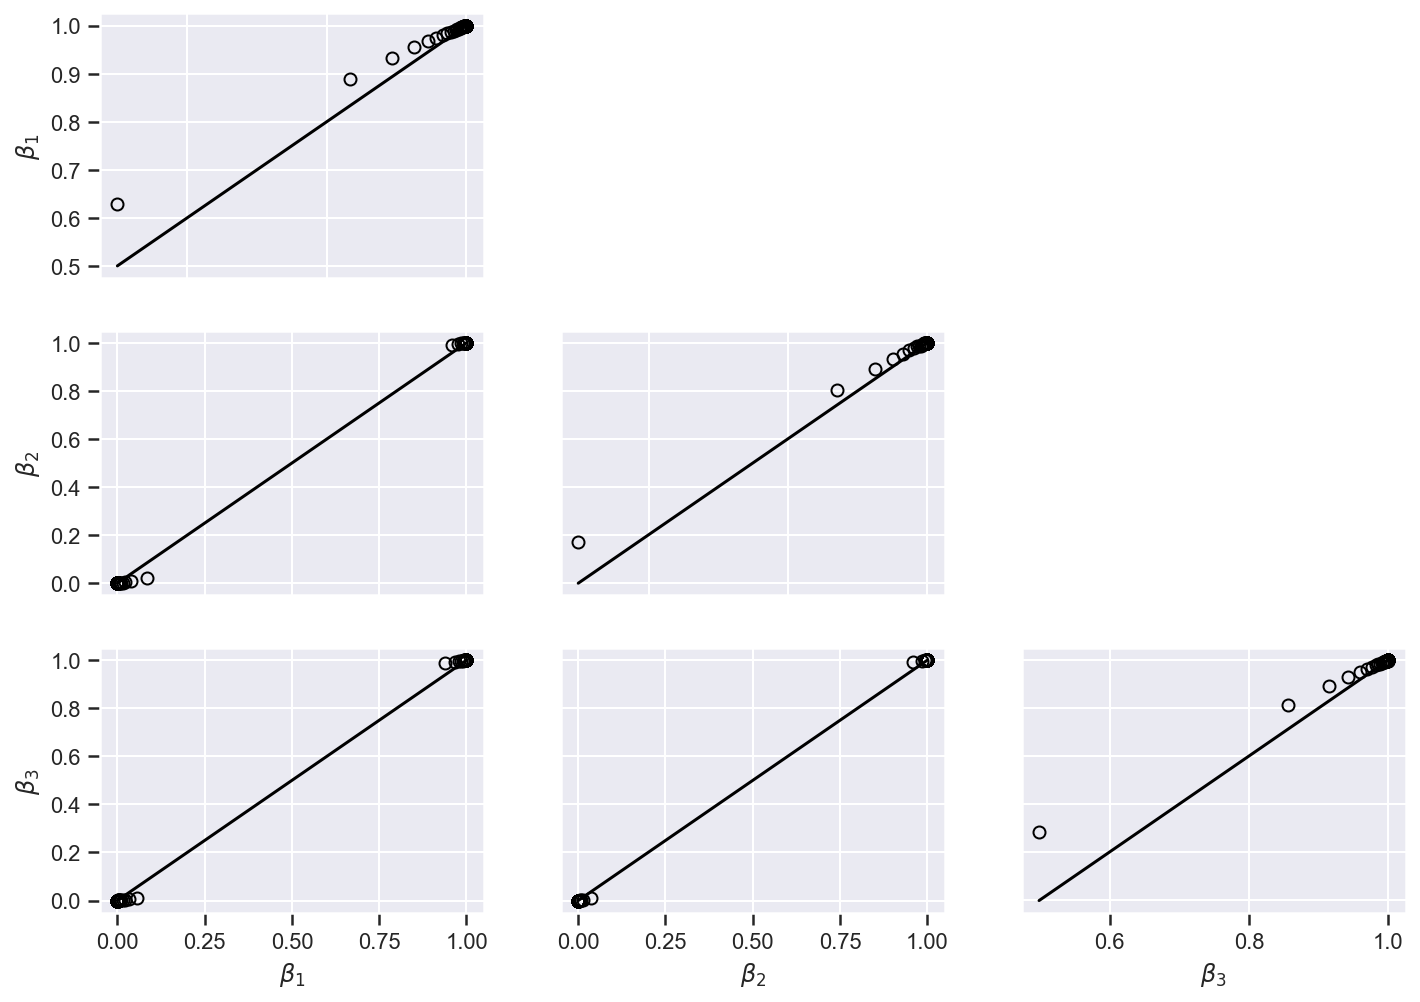

In [11]:
'''
Error 1: forget to include the transition probabilities when calculating the acceptance probabilities for the 'birth' and 'death' moves
'''
class bayes_lasso_sampler_error_1(bayes_lasso_sampler):
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      diff_log_joint = self.log_joint(
          beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
      threshold = diff_log_joint

      log_u = onp.log(rng.uniform())
      if log_u <= threshold:
        self._k = k_proposal
        self._gamma = gamma_proposal
        self._beta = beta_proposal
      return log_u, threshold

bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nthreads(nthreads)
bayes_lasso_error_1.drawData()
res_error_1 = test(bayes_lasso_error_1, num_samples=num_samples)

Geweke test
{'result': array([False, False, False,  True, False, False, False, False,  True]), 'p_value': array([2.89206154e-01, 5.25613559e-01, 2.92517911e-01, 2.29800546e-02,
       4.36381615e-01, 9.84448988e-02, 7.97557040e-01, 2.55835814e-01,
       3.29156846e-05]), 'test_statistic': array([-1.05986471, -0.63471615,  1.05261406, -2.27376608, -0.77831792,
       -1.65243994,  0.25651003,  1.13628857, -4.1522955 ]), 'critical_value': 1.959963984540054}
Test time: 8.281 seconds
Wild bootstrap MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 8.213410176339584, 'critical_value': 3.0396624321156933}
Test time: 1.29 seconds
Backward MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 1.9043581560254097, 'critical_value': 0.544188660569489, 'kernel_width': 1.0}
Test time: 8.281 seconds


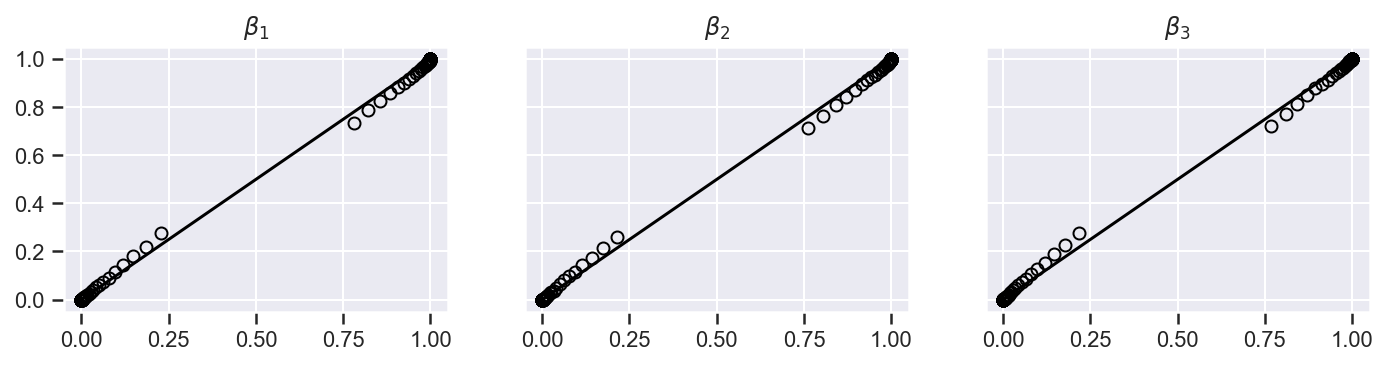

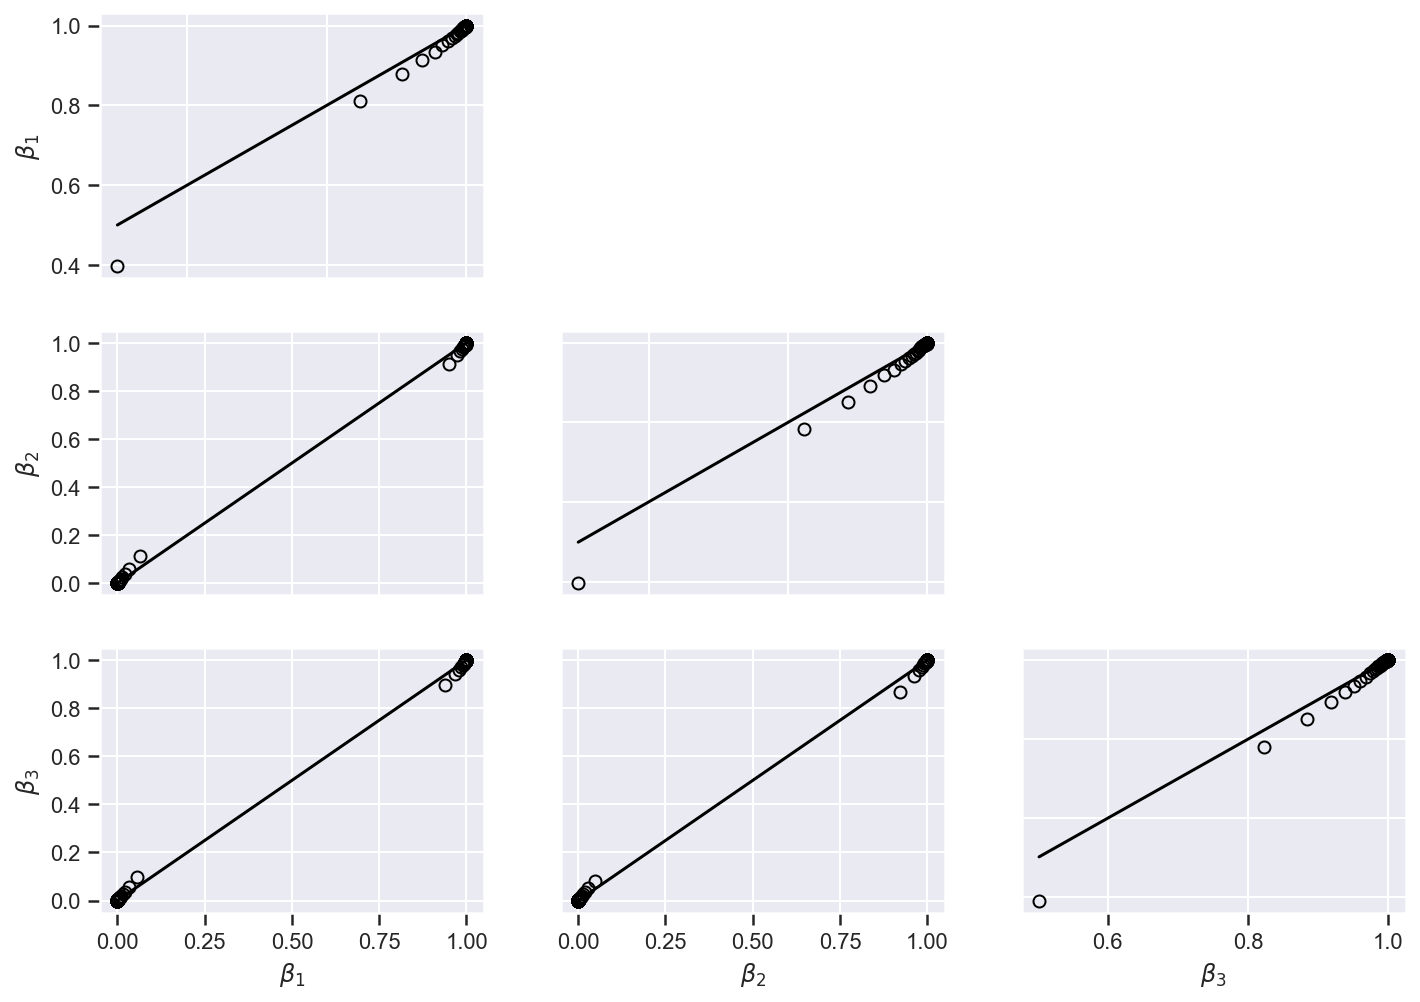

In [12]:
'''
Error 2: drop a '+1' in the log-prior calculation
'''
class bayes_lasso_sampler_error_2(bayes_lasso_sampler):
    def log_prior(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
    #   return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k+1) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # correct
      return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # error

bayes_lasso_error_2 = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_2.set_nthreads(nthreads)
bayes_lasso_error_2.drawData()
res_error_2 = test(bayes_lasso_error_2, num_samples=num_samples)

Both errors are detected by every test!

# Type I/II Error

We will now run `num_trials` instances of each test.

In [13]:
num_trials = 20
seed = 10000

In [14]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nthreads(nthreads)
bayes_lasso.set_seed(seed)
bayes_lasso.drawData()

run_experiment(bayes_lasso, 'default', num_trials)

Iteration time: 115.851 seconds
Iteration time: 114.272 seconds
Iteration time: 113.958 seconds
Iteration time: 112.621 seconds
Iteration time: 112.977 seconds
Iteration time: 112.308 seconds
Iteration time: 111.748 seconds
Iteration time: 116.009 seconds
Iteration time: 112.871 seconds
Iteration time: 116.765 seconds
Iteration time: 111.731 seconds
Iteration time: 111.58 seconds
Iteration time: 112.194 seconds
Iteration time: 110.521 seconds
Iteration time: 110.721 seconds
Iteration time: 110.849 seconds
Iteration time: 110.786 seconds
Iteration time: 109.906 seconds
Iteration time: 113.138 seconds
Iteration time: 111.076 seconds


In [15]:
bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nthreads(nthreads)
bayes_lasso_error_1.set_seed(seed)
bayes_lasso_error_1.drawData()

run_experiment(bayes_lasso_error_1, 'error_1', num_trials)

Iteration time: 107.818 seconds
Iteration time: 105.483 seconds
Iteration time: 103.845 seconds
Iteration time: 103.955 seconds
Iteration time: 104.588 seconds
Iteration time: 105.194 seconds
Iteration time: 111.119 seconds
Iteration time: 109.352 seconds
Iteration time: 110.135 seconds
Iteration time: 107.024 seconds
Iteration time: 107.945 seconds
Iteration time: 106.642 seconds
Iteration time: 107.45 seconds
Iteration time: 108.636 seconds
Iteration time: 119.915 seconds
Iteration time: 108.221 seconds
Iteration time: 107.815 seconds
Iteration time: 106.265 seconds
Iteration time: 107.666 seconds
Iteration time: 108.805 seconds


In [16]:
bayes_lasso = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_2.set_nthreads(nthreads)
bayes_lasso_error_2.set_seed(seed)
bayes_lasso_error_2.drawData()

run_experiment(bayes_lasso_error_2, 'error_2', num_trials)

Iteration time: 125.563 seconds
Iteration time: 118.354 seconds
Iteration time: 117.96 seconds
Iteration time: 120.252 seconds
Iteration time: 119.08 seconds
Iteration time: 119.631 seconds
Iteration time: 120.81 seconds
Iteration time: 118.844 seconds
Iteration time: 121.741 seconds
Iteration time: 120.241 seconds
Iteration time: 118.131 seconds
Iteration time: 120.191 seconds
Iteration time: 118.364 seconds
Iteration time: 119.695 seconds
Iteration time: 119.749 seconds
Iteration time: 116.735 seconds
Iteration time: 118.926 seconds
Iteration time: 116.574 seconds
Iteration time: 119.429 seconds
Iteration time: 121.479 seconds


Read results

In [23]:
import pandas as pd
num_trials = 20
df_results = pd.DataFrame(index=np.arange(0, num_trials*3), columns=('experiment', 'test_type', 'result'))
i=0
for exper in ['default', 'error_1', 'error_2']:
    with open('./results/bayes_lasso/experiment_' + exper + '.pkl', 'rb') as f:
        lst_res = pickle.load(f)
    for res in lst_res:
        df_results.loc[i] = [str(exper), 'geweke', onp.array(res['geweke']['result']).max()] # reject null if at least one test rejects
        df_results.loc[i+1] = [str(exper), 'backward', float(res['backward']['result'])]
        df_results.loc[i+2] = [str(exper), 'wild', float(res['wild']['result'])]
        i+=3
df_results['result'] = pd.to_numeric(df_results['result'])
df_results=df_results.groupby(['experiment', 'test_type']).mean()
df_results

result
experiment test_type        
default    backward     0.00
           geweke       0.55
           wild         0.00
error_1    backward     1.00
           geweke       1.00
           wild         1.00
error_2    backward     0.60
           geweke       0.85
           wild         0.95